# Alex Liddle
## University of Denver

# Chatbot
A chatbot is an intelligent piece of software that is capable of communicating and performing actions similar to a human. The goal of this project is to build a model that predicts answers using predefined patterns and responses. You are provided with a file named intents.json that contains these patterns. Words and classes files are provided as extra help. Feel free to make a more complex bot by extending the intents file. 

#### Possible chat with your bot
<code>
You: Hello, how are you? 
Bot: Hi there, how can I help?
You: what can you do?
Bot: I can guide you through Adverse drug reaction list, Blood pressure tracking, Hospitals and Pharmacies
You: thanks
Bot: My pleasure
You: see ya. got to go!
Bot: See you
</code>

In [127]:
import nltk
import string
import re
import sklearn
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from scipy import stats
#nltk.download('stopwords') #<---uncomment if you haven't downloaded the stopwords library
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [14]:
# Load pickle files
import urllib.request
import pickle

classes = pickle.load(urllib.request.urlopen("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectPCB/data/classes.pkl"))
words   = pickle.load(urllib.request.urlopen("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectPCB/data/words.pkl"))
print(classes)
print(words)

['adverse_drug', 'blood_pressure', 'blood_pressure_search', 'goodbye', 'greeting', 'hospital_search', 'options', 'pharmacy_search', 'thanks']
["'s", ',', 'a', 'adverse', 'all', 'anyone', 'are', 'awesome', 'be', 'behavior', 'blood', 'by', 'bye', 'can', 'causing', 'chatting', 'check', 'could', 'data', 'day', 'detail', 'do', 'dont', 'drug', 'entry', 'find', 'for', 'give', 'good', 'goodbye', 'have', 'hello', 'help', 'helpful', 'helping', 'hey', 'hi', 'history', 'hola', 'hospital', 'how', 'i', 'id', 'is', 'later', 'list', 'load', 'locate', 'log', 'looking', 'lookup', 'management', 'me', 'module', 'nearby', 'next', 'nice', 'of', 'offered', 'open', 'patient', 'pharmacy', 'pressure', 'provide', 'reaction', 'related', 'result', 'search', 'searching', 'see', 'show', 'suitable', 'support', 'task', 'thank', 'thanks', 'that', 'there', 'till', 'time', 'to', 'transfer', 'up', 'want', 'what', 'which', 'with', 'you']


In [15]:
# Load json file with answer patterns
import requests
import json

intents = json.loads(requests.get("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectPCB/data/intents.json").text)
intents

{'intents': [{'context': [''],
   'patterns': ['Hi there',
    'How are you',
    'Is anyone there?',
    'Hey',
    'Hola',
    'Hello',
    'Good day'],
   'responses': ['Hello, thanks for asking',
    'Good to see you again',
    'Hi there, how can I help?'],
   'tag': 'greeting'},
  {'context': [''],
   'patterns': ['Bye',
    'See you later',
    'Goodbye',
    'Nice chatting to you, bye',
    'Till next time'],
   'responses': ['See you!', 'Have a nice day', 'Bye! Come back again soon.'],
   'tag': 'goodbye'},
  {'context': [''],
   'patterns': ['Thanks',
    'Thank you',
    "That's helpful",
    'Awesome, thanks',
    'Thanks for helping me'],
   'responses': ['Happy to help!', 'Any time!', 'My pleasure'],
   'tag': 'thanks'},
  {'context': [''],
   'patterns': [],
   'responses': ["Sorry, can't understand you",
    'Please give me more info',
    'Not sure I understand'],
   'tag': 'noanswer'},
  {'context': [''],
   'patterns': ['How you could help me?',
    'What you can do?

Process patterns for nlp and clustering

In [154]:
df = pd.DataFrame(intents['intents'])
df_intents = pd.DataFrame({
              col:np.repeat(df[col].values, df['patterns'].str.len())
              for col in df.columns.difference(['patterns'])
          }).assign(**{'patterns':np.concatenate(df['patterns'].values)})[df.columns.tolist()]

In [155]:
tqdm.pandas()
stop = stopwords.words()

df_intents['patterns_vector'] = [[]]*len(df_intents.patterns.values)
#df_intents.patterns = df_intents.patterns.apply(' '.join)
for idx, val in df_intents.patterns.items():
    lowered = val.replace("[^\w\s]", "").lower()
    df_intents.set_value(idx, 'patterns_vector', ' '.join([item for item in lowered.split() 
                                                               if item not in stop]))
tfidf = TfidfVectorizer(
    min_df = 0,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english',
    use_idf = False,
)

tfidf.fit(df_intents.patterns_vector)
patterns_tfidf = tfidf.transform(df_intents.patterns_vector)

df_intents.patterns_vector = patterns_tfidf

df_intents.head()

,context,patterns,responses,tag,patterns_vector
0,[],Hi there,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 21)\t1.0\n (3, 20)\t1.0\n (4, 23)\t1.0..."
1,[],How are you,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 21)\t1.0\n (3, 20)\t1.0\n (4, 23)\t1.0..."
2,[],Is anyone there?,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 21)\t1.0\n (3, 20)\t1.0\n (4, 23)\t1.0..."
3,[],Hey,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 21)\t1.0\n (3, 20)\t1.0\n (4, 23)\t1.0..."
4,[],Hola,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 21)\t1.0\n (3, 20)\t1.0\n (4, 23)\t1.0..."


In [226]:
def find_optimal_clusters(data, max_k):    
    k_list = range(2, max_k+1)
    
    sse = []
    for k in k_list:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            #sse.append(KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(data).inertia_)
            sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)

    plt.style.use("dark_background")
    f, ax = plt.subplots(1, 1, figsize=(10,10))
    ax.plot(k_list, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(k_list)
    ax.set_xticklabels(k_list)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

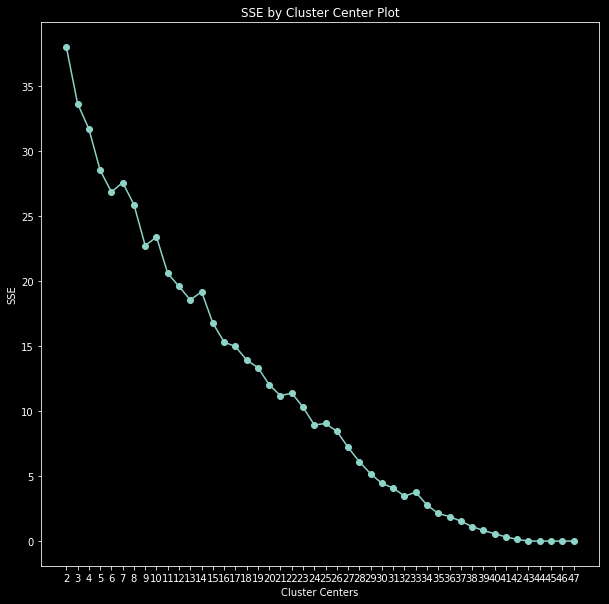

In [227]:
find_optimal_clusters(patterns_tfidf, patterns_tfidf.shape[0])

In [228]:
n_clusters = 43

#model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1).fit(patterns_tfidf)

model = MiniBatchKMeans(n_clusters=n_clusters, init_size=1024, batch_size=2048, 
                                            random_state=20).fit(patterns_tfidf)

df_intents['patterns_cluster'] = model.predict(patterns_tfidf)
df_intents

,context,patterns,responses,tag,patterns_vector,patterns_cluster
0,[],Hi there,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 21)\t1.0\n (3, 20)\t1.0\n (4, 23)\t1.0...",18
1,[],How are you,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 21)\t1.0\n (3, 20)\t1.0\n (4, 23)\t1.0...",3
2,[],Is anyone there?,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 21)\t1.0\n (3, 20)\t1.0\n (4, 23)\t1.0...",3
3,[],Hey,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 21)\t1.0\n (3, 20)\t1.0\n (4, 23)\t1.0...",16
4,[],Hola,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 21)\t1.0\n (3, 20)\t1.0\n (4, 23)\t1.0...",17
5,[],Hello,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 21)\t1.0\n (3, 20)\t1.0\n (4, 23)\t1.0...",25
6,[],Good day,"[Hello, thanks for asking, Good to see you aga...",greeting,"(0, 21)\t1.0\n (3, 20)\t1.0\n (4, 23)\t1.0...",26
7,[],Bye,"[See you!, Have a nice day, Bye! Come back aga...",goodbye,"(0, 21)\t1.0\n (3, 20)\t1.0\n (4, 23)\t1.0...",7
8,[],See you later,"[See you!, Have a nice day, Bye! Come back aga...",goodbye,"(0, 21)\t1.0\n (3, 20)\t1.0\n (4, 23)\t1.0...",21
9,[],Goodbye,"[See you!, Have a nice day, Bye! Come back aga...",goodbye,"(0, 21)\t1.0\n (3, 20)\t1.0\n (4, 23)\t1.0...",23


In [229]:
test = 'Show blood pressure results for patient'

lowered = test.replace("[^\w\s]", "").lower()
stripped = ' '.join([item for item in lowered.split() if item not in stop])

test_vector = tfidf.transform([stripped])

predicted_cluster = model.predict(test_vector)[0]

response = np.random.choice(list(df_intents[df_intents.patterns_cluster==predicted_cluster].responses)[0])

print(response)

Patient ID?
